# Soft Actor-Critic

https://arxiv.org/pdf/1801.01290.pdf

https://arxiv.org/pdf/1812.05905.pdf

SAC is an off-policy, model-free deep RL algorithm designed for continuous action spaces.

Reward maximization is augments with an entropy maximization term, thereby finding the "most random" policy that results in a large reward. (Original objective can be recovered through temperature parameter: https://arxiv.org/pdf/1702.08165.pdf)


The maximum entropy formulation provides "substantial improvements in exploration and robustness". That is, they are robust in the face of model and estimation errors and they improve "exploration by acquiring diverse behaviors". 

__The algorithm contains three components__:
1. Actor-critic architecture (separate policy and value functions)
2. Off-policy formulation - allows for reuse of previous experiences
3. Entropy maximization to enable stability and exploration

AC algos are derived from _policy iteration_ : alternating between policy evaluation (updating the value function) and policy improvement (using value function to obtain better policy). In practice, these two steps are usually optimized jointly.

SAC combines off-policy actor-critic training with __stochastic__ actor that is being trained to maximize its entropy. In addition, the actor is updates through an off-policy gradient.



### Maximum entropy objective:

$$
J(\pi) = \sum_{t=0}^{T} \mathbb{E}_{(s_t, a_t)\sim \rho_{\pi}}[r(s_t, a_t) + \alpha \mathcal{H}(\pi(\cdot | s_t))]
$$

Temperature $\alpha$ determines the relative importance of the entropy term against the reward. This results in control over the stochasticity of the policy. The original reward object is recovered with $\alpha = 0$.

### Derivation of Soft Policy Iteration
`A general algorithm for learning optimal maximum entropy policies that alternates betweenpolicy evaluation and policy improvement`

This is first introduced in a tabular setting, then extended to continuous later.

__Policy evaluation via iterative Bellman equation:__

$$
\mathcal{T}^{\pi}Q(s_t,a_t) := r(s_t,a_t) + \gamma \mathbb{E}_{s_{t+1}\sim p}[V(s_{t+1})] \\
V(s_t) = \mathbb{E}_{a_t \sim \pi}[Q(s_t,a_t) - log \pi (a_t|s_t)]
$$
where $\mathcal{T}$ is the Bellman backup operator.

__Policy improvement:__

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch import optim
import gym
from tqdm import tqdm
import matplotlib.pyplot as plt

In [187]:
!pip install pip install box2d-py

     |████████████████████████████████| 374 kB 7.0 MB/s eta 0:00:01
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp38-cp38-linux_x86_64.whl size=2165929 sha256=3e0ea9149f067ca6d43babf51aa68525f0ac2d53fd0135cafdc193008c1cd72d
  Stored in directory: /home/trevor/.cache/pip/wheels/cc/4f/d6/44eb0a9e6fea384e58f19cb0c4125e46a23af2b33fe3a7e81c
Successfully built box2d-py


### Replay memory

In [2]:
class ReplayMemory:
    """This is NOT for frame stacking!"""
    def __init__(self, mem_size, s_shape):
        self.mem_size = mem_size
        if isinstance(s_shape, list):
            self.s = np.zeros((mem_size, *s_shape))
            self.a = np.zeros(mem_size)
            self.r = np.zeros(mem_size)
            self.s_ = np.zeros((mem_size, *s_shape))
            self.t = np.zeros(mem_size)
        else:
            self.s = np.zeros((mem_size, s_shape))
            self.a = np.zeros(mem_size)
            self.r = np.zeros(mem_size)
            self.s_ = np.zeros((mem_size, s_shape))
            self.t = np.zeros(mem_size) 
        self.mem_cntr = 0
        
    def store(self, s, a, r, s_, t):
        idx = self.mem_cntr % self.mem_size
        self.s[idx] = s
        self.a[idx] = a
        self.r[idx] = r
        self.s_[idx] = s_
        self.t[idx] = 1 - t
        
        self.mem_cntr += 1
    
    def sample(self, batch_size):
        """We should probably handle the max_size<batch_size elsewhere?"""
        max_size = min(self.mem_cntr, self.mem_size)
        idxs = np.random.choice(max_size, size=batch_size, replace=False)
        return self.s[idxs], self.a[idxs], self.r[idxs], self.s_[idxs], self.t[idxs]

### Networks

The Value network, for non-image states, can be $Q(s,a)$ and we concatenate the vectors $s|a$.

For image states, can we simply use $V(s)$?

In [3]:
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)

class QNetwork(nn.Module):
    """
    Q(s,a)
    The original paper uses 2 layers with 256, 256
    """
    def __init__(self, s_shape, n_actions, lr, device='cpu'):
        super().__init__()
        self.inp = nn.Linear(s_shape + n_actions, 256)
        self.l1 = nn.Linear(256, 256)
        self.l2 = nn.Linear(256, 1)
        
        self.apply(weights_init_)
        
        self.to(device)        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        
    def forward(self, x):
        x = F.relu(self.inp(x))
        x = F.relu(self.l1(x))
        return self.l2(x)

class VNetwork(nn.Module):
    """
    V(s)
    This is for image-based states (for now)
    """
    def __init__(self, s_shape, lr, device='cpu'):
        super().__init__()
        # this form should handle cc being in any index
        self.inp = nn.Conv2d(min(s_shape), 8, (5, 5), stride=2)
        self.l1 = nn.Conv2d(8, 16, (3, 3), stride=2)
        self.l2 = nn.Conv2d(16, 4, (3, 3), stride=2)
        self.l3 = nn.Conv2d(4, 1, (3, 3), stride=2)
        self.d = nn.Linear(16, 1)
        
        self.to(device)        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    
    def forward(self, x):
        x = F.relu(self.inp(x))
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = x.view(x.size(0), -1)
        return self.d(x)

In [258]:
# class QNetwork(nn.Module):
#     def __init__(self, num_inputs, num_actions, hidden_dim):
#         super(QNetwork, self).__init__()

#         # Q1 architecture
#         self.linear1 = nn.Linear(num_inputs + num_actions, hidden_dim)
#         self.linear2 = nn.Linear(hidden_dim, hidden_dim)
#         self.linear3 = nn.Linear(hidden_dim, 1)

#         # Q2 architecture
#         self.linear4 = nn.Linear(num_inputs + num_actions, hidden_dim)
#         self.linear5 = nn.Linear(hidden_dim, hidden_dim)
#         self.linear6 = nn.Linear(hidden_dim, 1)
        
#         self.optimizer = optim.Adam(self.parameters(), lr=1e-3)

# #         self.apply(weights_init_)

#     def forward(self, state, action):
#         xu = torch.cat([state, action], 1)
        
#         x1 = F.relu(self.linear1(xu))
#         x1 = F.relu(self.linear2(x1))
#         x1 = self.linear3(x1)

#         x2 = F.relu(self.linear4(xu))
#         x2 = F.relu(self.linear5(x2))
#         x2 = self.linear6(x2)

#         return x1, x2

In [4]:
class PolicyNetwork(nn.Module):
    """
    
        Code from orig paper uses [-20, 2] for sigma clamping. This is strange?
            - instead, we recommend a very small number > 0
    """
    def __init__(self, s_shape, n_actions, lr, device='cpu', sigma_min=1e-6, sigma_max=2):
        super().__init__()
        self.inp = nn.Linear(s_shape, 256)
        self.l1 = nn.Linear(256, 256)
        self.mu = nn.Linear(256, n_actions)
        self.sigma = nn.Linear(256, n_actions)
        
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        
        self.to(device)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        
    def forward(self, x):
        x = F.relu(self.inp(x))
        x = F.relu(self.l1(x))
        mus = self.mu(x)
        sigmas = self.sigma(x)
        sigmas = torch.clamp(sigmas, self.sigma_min, self.sigma_max)
        return mus, sigmas
    
    def sample_action(self, s):
        mus, sigmas = self.forward(s)
        # Why do we exponentiate the std?
        spherical_g = Normal(mus, sigmas.exp())
        
        # The .rsample() method has the reparameterization trick built in
        # https://pytorch.org/docs/stable/_modules/torch/distributions/normal.html#Normal.rsample
        # mu + eps * sigma where eps ~N(0,1)
        actions = spherical_g.rsample()
        action_tanh = torch.tanh(actions) 
        
        # Next we enforce the action-bound
        log_probs = spherical_g.log_prob(actions)
        log_probs -= torch.log(1 - action_tanh.pow(2) + 1e-6)
        log_probs = log_probs.sum(1, keepdim=True)
        return action_tanh, log_probs

### Agent

In [295]:
env.action_space.shape

(1,)

In [297]:
-torch.prod(torch.Tensor(env.action_space.shape)).item()

-1.0

In [34]:
-torch.prod(torch.tensor(5))

tensor(-5)

In [37]:
import numpy as np
np.log(0.01)

-4.605170185988091

In [38]:
class SAC:
    """
    
    pi=actor
    """
    def __init__(self, s_shape, n_actions, mem_size, batch_size, device='cpu',
                 lr=3e-4, gamma=0.99, tau=0.005, alpha=0.05):
        self.q1 = QNetwork(s_shape, n_actions, lr, device)
        self.q2 = QNetwork(s_shape, n_actions, lr, device)
        self.qtarget1 = QNetwork(s_shape, n_actions, lr, device)
        self.qtarget2 = QNetwork(s_shape, n_actions, lr, device)
        self.pi = PolicyNetwork(s_shape, n_actions, lr, device)
        
        self.memory = ReplayMemory(mem_size, s_shape)
        self.device = device
        
        self.batch_size = batch_size
        self.gamma = torch.tensor(gamma, dtype=torch.float)
        self.tau = torch.tensor(tau, dtype=torch.float)
        self.alpha = torch.tensor(alpha, dtype=torch.float) # optimizer needs tensor
        
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr)
        
        self.target_entropy = -torch.prod(torch.Tensor(env.action_space.shape))
        self._safe_init_()
    
    def _safe_init_(self):
        """only used in the beginning to set all targets equal to their respective net
            and to send all scalars to the appropriate device
        """
        self.qtarget1.load_state_dict(self.q1.state_dict())
        self.qtarget2.load_state_dict(self.q2.state_dict())
        self.gamma.to(self.device)
        self.tau.to(self.device)
        self.alpha.to(self.device)
        self.target_entropy.to(self.device)
    
    def soft_param_update(self):
        """We perform the soft update by looping through the parameters
            within the state_dict of each target networks. There is no need to
            load_state_dict() as the math is NOT done on a copy but the original
        """
        q1_params = self.q1.state_dict()
        q1_target_params = self.qtarget1.state_dict()
        
        for key in q1_params.keys():
            q1_target_params[key] = q1_params[key] *  self.tau + (1 - self.tau) * q1_target_params[key]
        
        self.qtarget1.load_state_dict(q1_target_params)
        
        q2_params = self.q2.state_dict()
        q2_target_params = self.qtarget2.state_dict()
        
        for key in q2_params.keys():
            q2_target_params[key] = q2_params[key] * self.tau + (1 - self.tau) * q2_target_params[key]
        
        self.qtarget2.load_state_dict(q2_target_params)
        
    def sample_action(self, s):
        s = torch.tensor(s, dtype=torch.float).unsqueeze(0)
        a, _ = self.pi.sample_action(s.to(self.device))
        return a.cpu().detach().numpy()[0]
    
    def remember(self, s, a, r, s_, t):
        self.memory.store(s, a, r, s_, t)
    
    def learn(self, logs=False, verbose=False):
        """Performs a single learning batch"""
        if self.memory.mem_cntr < self.batch_size:
            return
        
        s, a, r, s_, t = self.memory.sample(self.batch_size)
        
        # .unsqueeze(1): [1, 2, 3] --> [[1], [2], [3]]
        s = torch.tensor(s, dtype=torch.float)
        a = torch.tensor(a, dtype=torch.float).unsqueeze(1)
        r = torch.tensor(r, dtype=torch.float).unsqueeze(1)
        s_ = torch.tensor(s_, dtype=torch.float)
        t = torch.tensor(t, dtype=torch.float).unsqueeze(1)
        
        # (1) For each QNetwork, update the parameters using MSE
        # JQ = 𝔼_{st,at}~D[0.5(Q(st,at) - r(st,at) - γ(𝔼_{s_{t+1}~p}[V(s_{t+1})]))^2]
        # s|a needs to happen along dim=1 as we are dealing with batched data
        sa_cat = torch.cat([s, a], dim=1)
        q_sa1 = self.q1(sa_cat.to(self.device))
        q_sa2 = self.q2(sa_cat.to(self.device))
        q_sa = torch.min(q_sa1, q_sa2) # getting fukt?
        
        # Now we need to get the next state which in the paper is described as V(s_{t+1})
        # V(s) = Q(s,a) - alpha * log pi(a|s)
        # We do not need the gradients for this portion...
        with torch.no_grad():          
            next_a, next_a_log_probs = self.pi.sample_action(s_.to(self.device))
            next_sa_cat = torch.cat([s_.to(self.device), next_a], dim=1)
            next_q_sa1 = self.qtarget1(next_sa_cat)
            next_q_sa2 = self.qtarget2(next_sa_cat)
            next_q_sa = torch.min(next_q_sa1, next_q_sa2) - self.alpha * next_a_log_probs
            target = r.to(self.device) + t.to(self.device) * self.gamma * next_q_sa
            

        q1_loss = F.mse_loss(q_sa1, target)
        q2_loss = F.mse_loss(q_sa2, target)
        
        self.q1.optimizer.zero_grad()
        q1_loss.backward()
        self.q1.optimizer.step()
        
        self.q2.optimizer.zero_grad()
        q2_loss.backward()
        self.q2.optimizer.step()
        
        # (2) Update the policy network 
        # Re-computing q_sa based on the new sample
        a, a_log_probs = self.pi.sample_action(s.to(self.device))
        sa_cat = torch.cat([s.to(self.device), a], dim=1)
        q_sa1 = self.q1(sa_cat)
        q_sa2 = self.q2(sa_cat)
        q_sa = torch.min(q_sa1, q_sa2) 
        
        pi_loss = (self.alpha * a_log_probs - q_sa).mean()
        self.pi.optimizer.zero_grad()
        pi_loss.backward()
        self.pi.optimizer.step()
        
        # (3) Auto-tuning the entropy parameter using the original github reference
        # https://github.com/rail-berkeley/softlearning/blob/master/softlearning/algorithms/sac.py
        alpha_loss = - (
            self.log_alpha * (a_log_probs + self.target_entropy).detach()
        ).mean()
        
        if verbose:
            print(self.log_alpha)
            print(a_log_probs)
            print(self.target_entropy)
        
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp()
        
        if logs:
            return q1_loss.item(), q2_loss.item(), pi_loss.item(), alpha_loss.item(), self.alpha.clone().item()
            

In [6]:
from torch.distributions import Categorical
import torch.nn.functional as F
import torch

In [9]:
probs = F.softmax(torch.tensor([
    10, 3, 5, 8, 22, .3
]), dim=-1)

In [10]:
probs

tensor([6.1442e-06, 5.6028e-09, 4.1399e-08, 8.3152e-07, 9.9999e-01, 3.7654e-10])

In [11]:
p = Categorical(probs)

In [32]:
torch.argmax(probs)

tensor(4)

In [39]:
env = gym.make('Pendulum-v0')

/home/trevor/anaconda3/envs/torch/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [40]:
agent = SAC(
    s_shape=3, n_actions=1, mem_size=100000, batch_size=256, 
    device='cuda', lr=3e-4, gamma=0.99, tau=0.005, alpha=0.05
)

In [41]:
r_hist = []

q1_loss_hist = []
q2_loss_hist = []
pi_loss_hist = []
alpha_loss_hist = []
alpha_hist = []

N_EPS = 10000

for i in tqdm(range(N_EPS)):
    inner_r = []
    inner_q1_loss_hist = []
    inner_q2_loss_hist = []
    inner_pi_loss_hist = []
    inner_alpha_loss_hist = []
    inner_alpha_hist = []
    s = env.reset()
    done = False
    
    while not done:
        a = agent.sample_action(s)
        s_, r, t, _ = env.step(a)
        inner_r.append(r)
        agent.remember(s, a, r, s_, t)
        
        if t:
            done = True
        try:
            q1_loss, q2_loss, pi_loss, alpha_loss, alpha = agent.learn(logs=True)
            inner_q1_loss_hist.append(q1_loss)
            inner_q2_loss_hist.append(q2_loss)
            inner_pi_loss_hist.append(pi_loss)
            inner_alpha_loss_hist.append(alpha_loss)
            inner_alpha_hist.append(alpha)
        except:
            continue
        
        s = s_
    r_hist.append(np.sum(inner_r)) 
    
    if len(inner_q1_loss_hist) > 0:
        q1_loss_hist.append(np.mean(inner_q1_loss_hist))
        q2_loss_hist.append(np.mean(inner_q2_loss_hist))
        pi_loss_hist.append(np.mean(inner_pi_loss_hist))
        alpha_loss_hist.append(np.mean(inner_alpha_loss_hist))
        alpha_hist.append(np.mean(inner_alpha_hist))
        
    agent.soft_param_update()
    
    if (i+1) % 100 == 0:
        print(
            f'R: {round(np.mean(r_hist[-50:]), 3)}, Q1: {round(np.mean(q1_loss_hist[-100:]), 3)}, Q2: {round(np.mean(q2_loss_hist[-100:]), 3)}, Pi: {round(np.mean(pi_loss_hist[-100:]), 3)}, A: {round(np.mean(alpha_loss_hist[-100:]), 3)}, a: {round(np.mean(alpha_hist[-100:]), 3)}'
        ) 

  1%|          | 100/10000 [03:47<6:27:50,  2.35s/it]

R: -1521.475, Q1: 1.045, Q2: 1.033, Pi: 6.703, A: -3.247, a: 0.171


  2%|▏         | 200/10000 [07:38<6:09:23,  2.26s/it]

R: -1612.198, Q1: 0.297, Q2: 0.297, Pi: 9.965, A: 0.076, a: 0.005


  3%|▎         | 300/10000 [11:40<6:27:49,  2.40s/it]

R: -1579.065, Q1: 0.419, Q2: 0.42, Pi: 13.058, A: 0.052, a: 0.008


  4%|▍         | 400/10000 [15:50<6:53:27,  2.58s/it]

R: -1583.455, Q1: 0.676, Q2: 0.676, Pi: 16.266, A: 0.05, a: 0.011


  5%|▌         | 500/10000 [20:09<6:58:49,  2.65s/it]

R: -1570.541, Q1: 1.094, Q2: 1.095, Pi: 19.651, A: 0.027, a: 0.014


  6%|▌         | 600/10000 [24:30<6:56:23,  2.66s/it]

R: -1539.766, Q1: 1.444, Q2: 1.444, Pi: 23.516, A: 0.043, a: 0.018


  7%|▋         | 700/10000 [28:52<6:45:40,  2.62s/it]

R: -1480.852, Q1: 2.118, Q2: 2.118, Pi: 27.121, A: 0.031, a: 0.024


  8%|▊         | 800/10000 [33:13<6:40:38,  2.61s/it]

R: -1394.125, Q1: 2.89, Q2: 2.89, Pi: 30.301, A: 0.02, a: 0.032


  9%|▉         | 900/10000 [37:34<6:25:28,  2.54s/it]

R: -1365.322, Q1: 3.565, Q2: 3.564, Pi: 33.144, A: 0.022, a: 0.041


 10%|█         | 1000/10000 [41:57<6:31:34,  2.61s/it]

R: -1316.666, Q1: 4.183, Q2: 4.182, Pi: 35.578, A: -0.004, a: 0.045


 11%|█         | 1100/10000 [46:18<6:22:11,  2.58s/it]

R: -1280.194, Q1: 4.673, Q2: 4.673, Pi: 37.595, A: 0.009, a: 0.048


 12%|█▏        | 1200/10000 [50:40<6:26:46,  2.64s/it]

R: -1295.196, Q1: 5.117, Q2: 5.117, Pi: 39.427, A: 0.007, a: 0.054


 13%|█▎        | 1300/10000 [55:02<6:20:30,  2.62s/it]

R: -1248.621, Q1: 5.603, Q2: 5.602, Pi: 41.317, A: 0.013, a: 0.061


 14%|█▍        | 1400/10000 [59:24<6:16:14,  2.62s/it]

R: -1177.798, Q1: 6.414, Q2: 6.411, Pi: 43.145, A: 0.001, a: 0.067


 15%|█▌        | 1500/10000 [1:03:43<6:08:24,  2.60s/it]

R: -1149.583, Q1: 7.25, Q2: 7.247, Pi: 44.649, A: 0.004, a: 0.073


 16%|█▌        | 1600/10000 [1:07:54<5:58:38,  2.56s/it]

R: -1122.813, Q1: 8.186, Q2: 8.183, Pi: 46.077, A: 0.004, a: 0.077


 17%|█▋        | 1700/10000 [1:12:06<5:41:49,  2.47s/it]

R: -1027.022, Q1: 9.02, Q2: 9.02, Pi: 47.149, A: 0.003, a: 0.082


 18%|█▊        | 1800/10000 [1:16:23<5:54:24,  2.59s/it]

R: -1045.651, Q1: 10.014, Q2: 10.015, Pi: 47.799, A: 0.005, a: 0.083


 19%|█▉        | 1900/10000 [1:20:43<5:50:20,  2.60s/it]

R: -1035.263, Q1: 10.977, Q2: 10.979, Pi: 48.649, A: 0.006, a: 0.094


 20%|██        | 2000/10000 [1:25:05<5:52:03,  2.64s/it]

R: -1032.002, Q1: 11.542, Q2: 11.542, Pi: 49.771, A: 0.002, a: 0.102


 21%|██        | 2100/10000 [1:29:27<5:36:54,  2.56s/it]

R: -920.941, Q1: 11.909, Q2: 11.909, Pi: 50.78, A: 0.003, a: 0.108


 22%|██▏       | 2200/10000 [1:33:49<5:38:46,  2.61s/it]

R: -955.657, Q1: 12.201, Q2: 12.203, Pi: 51.528, A: 0.006, a: 0.118


 23%|██▎       | 2300/10000 [1:38:11<5:27:46,  2.55s/it]

R: -901.2, Q1: 12.786, Q2: 12.789, Pi: 52.343, A: 0.002, a: 0.13


 24%|██▍       | 2400/10000 [1:42:32<5:38:50,  2.68s/it]

R: -786.449, Q1: 12.531, Q2: 12.533, Pi: 51.987, A: 0.001, a: 0.132


 25%|██▌       | 2500/10000 [1:46:52<5:36:18,  2.69s/it]

R: -740.231, Q1: 12.103, Q2: 12.105, Pi: 50.747, A: 0.002, a: 0.138


 26%|██▌       | 2600/10000 [1:51:15<5:15:07,  2.56s/it]

R: -600.384, Q1: 11.168, Q2: 11.171, Pi: 48.643, A: -0.001, a: 0.138


 27%|██▋       | 2700/10000 [1:55:35<5:12:17,  2.57s/it]

R: -482.988, Q1: 9.8, Q2: 9.804, Pi: 45.856, A: -0.002, a: 0.135


 28%|██▊       | 2800/10000 [1:59:56<5:06:51,  2.56s/it]

R: -452.853, Q1: 7.773, Q2: 7.778, Pi: 41.603, A: -0.005, a: 0.122


 29%|██▉       | 2900/10000 [2:04:09<4:57:34,  2.51s/it]

R: -336.052, Q1: 5.688, Q2: 5.691, Pi: 37.61, A: -0.011, a: 0.107


 30%|███       | 3000/10000 [2:08:21<4:58:29,  2.56s/it]

R: -346.132, Q1: 3.848, Q2: 3.849, Pi: 32.702, A: -0.016, a: 0.082


 31%|███       | 3100/10000 [2:12:32<4:58:01,  2.59s/it]

R: -326.243, Q1: 2.424, Q2: 2.425, Pi: 28.53, A: -0.027, a: 0.058


 32%|███▏      | 3200/10000 [2:16:47<4:43:10,  2.50s/it]

R: -283.618, Q1: 1.296, Q2: 1.297, Pi: 25.215, A: -0.03, a: 0.038


 33%|███▎      | 3300/10000 [2:21:00<4:41:02,  2.52s/it]

R: -258.133, Q1: 0.684, Q2: 0.684, Pi: 22.785, A: -0.046, a: 0.024


 34%|███▍      | 3400/10000 [2:25:12<4:27:07,  2.43s/it]

R: -236.398, Q1: 0.224, Q2: 0.224, Pi: 20.487, A: -0.052, a: 0.015


 35%|███▌      | 3500/10000 [2:29:23<4:24:03,  2.44s/it]

R: -241.271, Q1: 0.089, Q2: 0.089, Pi: 19.634, A: -0.044, a: 0.01


 36%|███▌      | 3600/10000 [2:33:33<4:37:10,  2.60s/it]

R: -287.097, Q1: 0.019, Q2: 0.019, Pi: 18.879, A: -0.035, a: 0.007


 37%|███▋      | 3700/10000 [2:37:42<4:20:57,  2.49s/it]

R: -242.828, Q1: 0.017, Q2: 0.017, Pi: 18.534, A: -0.014, a: 0.006


 38%|███▊      | 3800/10000 [2:41:57<4:28:08,  2.59s/it]

R: -255.616, Q1: 0.017, Q2: 0.017, Pi: 18.503, A: -0.019, a: 0.006


 39%|███▉      | 3900/10000 [2:46:16<4:27:44,  2.63s/it]

R: -255.779, Q1: 0.017, Q2: 0.017, Pi: 18.771, A: 0.004, a: 0.005


 40%|████      | 4000/10000 [2:50:35<4:20:05,  2.60s/it]

R: -255.932, Q1: 0.017, Q2: 0.017, Pi: 19.037, A: 0.005, a: 0.005


 41%|████      | 4100/10000 [2:54:56<4:10:41,  2.55s/it]

R: -225.191, Q1: 0.016, Q2: 0.017, Pi: 19.127, A: -0.016, a: 0.005


 42%|████▏     | 4200/10000 [2:59:09<3:59:54,  2.48s/it]

R: -252.047, Q1: 0.017, Q2: 0.017, Pi: 18.853, A: 0.013, a: 0.005


 43%|████▎     | 4300/10000 [3:03:20<3:59:28,  2.52s/it]

R: -262.316, Q1: 0.017, Q2: 0.018, Pi: 19.247, A: 0.021, a: 0.005


 44%|████▍     | 4400/10000 [3:07:33<3:59:06,  2.56s/it]

R: -286.928, Q1: 0.017, Q2: 0.018, Pi: 19.9, A: 0.002, a: 0.006


 45%|████▌     | 4500/10000 [3:11:44<3:49:55,  2.51s/it]

R: -265.395, Q1: 0.018, Q2: 0.018, Pi: 20.542, A: 0.016, a: 0.006


 46%|████▌     | 4600/10000 [3:15:55<3:45:54,  2.51s/it]

R: -277.454, Q1: 0.026, Q2: 0.027, Pi: 20.88, A: 0.096, a: 0.008


 47%|████▋     | 4700/10000 [3:20:03<3:40:39,  2.50s/it]

R: -271.897, Q1: 0.02, Q2: 0.021, Pi: 21.663, A: -0.025, a: 0.008


 48%|████▊     | 4800/10000 [3:24:16<3:44:45,  2.59s/it]

R: -244.146, Q1: 0.02, Q2: 0.021, Pi: 21.791, A: -0.014, a: 0.007


 49%|████▉     | 4900/10000 [3:28:35<3:40:28,  2.59s/it]

R: -234.681, Q1: 0.022, Q2: 0.023, Pi: 21.491, A: -0.019, a: 0.006


 50%|█████     | 5000/10000 [3:32:56<3:39:24,  2.63s/it]

R: -251.177, Q1: 0.021, Q2: 0.023, Pi: 21.072, A: -0.022, a: 0.006


 51%|█████     | 5100/10000 [3:37:17<3:35:49,  2.64s/it]

R: -257.209, Q1: 0.022, Q2: 0.024, Pi: 21.427, A: 0.032, a: 0.006


 52%|█████▏    | 5200/10000 [3:41:26<3:20:50,  2.51s/it]

R: -248.73, Q1: 0.023, Q2: 0.024, Pi: 21.176, A: 0.005, a: 0.006


 53%|█████▎    | 5300/10000 [3:45:36<3:13:10,  2.47s/it]

R: -243.966, Q1: 0.027, Q2: 0.028, Pi: 21.215, A: 0.034, a: 0.007


 54%|█████▍    | 5400/10000 [3:49:47<3:03:34,  2.39s/it]

R: -224.025, Q1: 0.027, Q2: 0.028, Pi: 21.371, A: 0.013, a: 0.008


 55%|█████▌    | 5500/10000 [3:53:59<3:11:17,  2.55s/it]

R: -253.812, Q1: 0.029, Q2: 0.031, Pi: 21.657, A: 0.019, a: 0.009


 56%|█████▌    | 5600/10000 [3:58:09<2:57:00,  2.41s/it]

R: -274.079, Q1: 0.03, Q2: 0.033, Pi: 21.717, A: 0.006, a: 0.01


 57%|█████▋    | 5700/10000 [4:02:21<3:04:38,  2.58s/it]

R: -265.88, Q1: 0.033, Q2: 0.036, Pi: 22.365, A: -0.0, a: 0.01


 58%|█████▊    | 5800/10000 [4:06:33<2:54:37,  2.49s/it]

R: -237.061, Q1: 0.037, Q2: 0.042, Pi: 22.568, A: 0.016, a: 0.011


 59%|█████▉    | 5900/10000 [4:10:43<2:51:22,  2.51s/it]

R: -241.091, Q1: 0.039, Q2: 0.044, Pi: 22.314, A: 0.034, a: 0.013


 60%|██████    | 6000/10000 [4:14:54<2:51:18,  2.57s/it]

R: -240.318, Q1: 0.045, Q2: 0.05, Pi: 22.571, A: 0.01, a: 0.015


 61%|██████    | 6100/10000 [4:19:04<2:41:25,  2.48s/it]

R: -205.635, Q1: 0.046, Q2: 0.05, Pi: 22.644, A: -0.001, a: 0.016


 62%|██████▏   | 6200/10000 [4:23:16<2:40:20,  2.53s/it]

R: -245.559, Q1: 0.047, Q2: 0.054, Pi: 22.193, A: -0.008, a: 0.015


 63%|██████▎   | 6300/10000 [4:27:27<2:35:47,  2.53s/it]

R: -287.978, Q1: 0.049, Q2: 0.055, Pi: 22.852, A: -0.028, a: 0.014


 64%|██████▍   | 6400/10000 [4:31:37<2:25:56,  2.43s/it]

R: -271.323, Q1: 0.052, Q2: 0.059, Pi: 24.29, A: -0.004, a: 0.012


 65%|██████▌   | 6500/10000 [4:35:47<2:27:20,  2.53s/it]

R: -254.853, Q1: 0.053, Q2: 0.059, Pi: 25.225, A: -0.029, a: 0.011


 66%|██████▌   | 6600/10000 [4:39:57<2:19:41,  2.47s/it]

R: -260.763, Q1: 0.071, Q2: 0.081, Pi: 25.526, A: -0.016, a: 0.009


 67%|██████▋   | 6700/10000 [4:44:07<2:18:18,  2.51s/it]

R: -250.834, Q1: 0.063, Q2: 0.071, Pi: 26.44, A: -0.003, a: 0.008


 68%|██████▊   | 6800/10000 [4:48:16<2:12:02,  2.48s/it]

R: -273.033, Q1: 0.069, Q2: 0.075, Pi: 26.126, A: -0.004, a: 0.007


 69%|██████▉   | 6900/10000 [4:52:27<2:08:14,  2.48s/it]

R: -301.971, Q1: 0.075, Q2: 0.081, Pi: 25.727, A: 0.028, a: 0.008


 70%|███████   | 7000/10000 [4:56:37<2:04:32,  2.49s/it]

R: -258.429, Q1: 0.077, Q2: 0.084, Pi: 25.889, A: 0.048, a: 0.01


 71%|███████   | 7100/10000 [5:00:47<1:59:43,  2.48s/it]

R: -251.832, Q1: 0.084, Q2: 0.095, Pi: 25.994, A: 0.013, a: 0.012


 72%|███████▏  | 7200/10000 [5:04:58<1:53:34,  2.43s/it]

R: -271.99, Q1: 0.091, Q2: 0.103, Pi: 25.277, A: 0.02, a: 0.014


 73%|███████▎  | 7300/10000 [5:09:08<1:51:33,  2.48s/it]

R: -243.0, Q1: 0.096, Q2: 0.109, Pi: 25.856, A: -0.004, a: 0.015


 74%|███████▍  | 7400/10000 [5:13:18<1:49:28,  2.53s/it]

R: -236.362, Q1: 0.123, Q2: 0.134, Pi: 25.715, A: -0.006, a: 0.014


 75%|███████▌  | 7500/10000 [5:17:28<1:43:40,  2.49s/it]

R: -211.01, Q1: 0.12, Q2: 0.13, Pi: 25.278, A: -0.006, a: 0.013


 76%|███████▌  | 7600/10000 [5:21:36<1:41:14,  2.53s/it]

R: -246.305, Q1: 0.113, Q2: 0.129, Pi: 24.914, A: -0.069, a: 0.01


 77%|███████▋  | 7700/10000 [5:25:48<1:38:27,  2.57s/it]

R: -220.892, Q1: 0.116, Q2: 0.131, Pi: 25.242, A: -0.027, a: 0.008


 78%|███████▊  | 7800/10000 [5:29:57<1:31:23,  2.49s/it]

R: -240.484, Q1: 0.123, Q2: 0.141, Pi: 24.475, A: 0.016, a: 0.007


 79%|███████▉  | 7900/10000 [5:34:09<1:29:39,  2.56s/it]

R: -229.772, Q1: 0.124, Q2: 0.139, Pi: 24.306, A: -0.012, a: 0.008


 80%|████████  | 8000/10000 [5:38:19<1:24:14,  2.53s/it]

R: -322.977, Q1: 0.128, Q2: 0.145, Pi: 24.466, A: 0.006, a: 0.007


 81%|████████  | 8100/10000 [5:42:28<1:18:14,  2.47s/it]

R: -227.063, Q1: 0.204, Q2: 0.22, Pi: 26.078, A: 0.038, a: 0.008


 82%|████████▏ | 8200/10000 [5:46:40<1:16:10,  2.54s/it]

R: -254.49, Q1: 0.149, Q2: 0.166, Pi: 26.326, A: -0.029, a: 0.007


 83%|████████▎ | 8300/10000 [5:50:50<1:11:06,  2.51s/it]

R: -220.532, Q1: 0.151, Q2: 0.172, Pi: 27.239, A: -0.019, a: 0.007


 84%|████████▍ | 8400/10000 [5:55:01<1:07:38,  2.54s/it]

R: -241.333, Q1: 0.151, Q2: 0.177, Pi: 27.391, A: 0.031, a: 0.007


 85%|████████▌ | 8500/10000 [5:59:13<1:03:23,  2.54s/it]

R: -228.424, Q1: 0.177, Q2: 0.215, Pi: 27.924, A: 0.082, a: 0.008


 86%|████████▌ | 8600/10000 [6:03:22<59:07,  2.53s/it]  

R: -237.571, Q1: 0.177, Q2: 0.215, Pi: 27.15, A: -0.019, a: 0.009


 87%|████████▋ | 8700/10000 [6:07:33<54:13,  2.50s/it]

R: -269.085, Q1: 0.172, Q2: 0.203, Pi: 27.297, A: 0.007, a: 0.01


 88%|████████▊ | 8800/10000 [6:11:42<49:35,  2.48s/it]

R: -260.989, Q1: 0.174, Q2: 0.209, Pi: 27.873, A: 0.025, a: 0.011


 89%|████████▉ | 8900/10000 [6:15:52<45:52,  2.50s/it]

R: -227.537, Q1: 0.188, Q2: 0.228, Pi: 28.093, A: 0.018, a: 0.013


 90%|█████████ | 9000/10000 [6:20:03<41:44,  2.50s/it]

R: -241.141, Q1: 0.191, Q2: 0.231, Pi: 27.9, A: -0.023, a: 0.012


 91%|█████████ | 9100/10000 [6:24:14<37:49,  2.52s/it]

R: -230.692, Q1: 0.19, Q2: 0.222, Pi: 27.955, A: -0.018, a: 0.011


 92%|█████████▏| 9200/10000 [6:28:26<33:28,  2.51s/it]

R: -242.347, Q1: 0.183, Q2: 0.212, Pi: 28.046, A: -0.002, a: 0.011


 93%|█████████▎| 9300/10000 [6:32:36<29:17,  2.51s/it]

R: -266.584, Q1: 0.189, Q2: 0.216, Pi: 27.55, A: -0.018, a: 0.01


 94%|█████████▍| 9400/10000 [6:36:46<25:23,  2.54s/it]

R: -246.282, Q1: 0.21, Q2: 0.229, Pi: 27.403, A: 0.013, a: 0.008


 95%|█████████▌| 9500/10000 [6:40:55<20:04,  2.41s/it]

R: -273.086, Q1: 0.216, Q2: 0.24, Pi: 27.416, A: -0.011, a: 0.008


 96%|█████████▌| 9600/10000 [6:45:06<16:33,  2.48s/it]

R: -209.545, Q1: 0.213, Q2: 0.251, Pi: 28.126, A: 0.046, a: 0.01


 97%|█████████▋| 9700/10000 [6:49:16<12:17,  2.46s/it]

R: -283.199, Q1: 0.223, Q2: 0.252, Pi: 27.757, A: -0.025, a: 0.01


 98%|█████████▊| 9800/10000 [6:53:27<08:23,  2.52s/it]

R: -267.376, Q1: 0.236, Q2: 0.263, Pi: 28.494, A: 0.035, a: 0.011


 99%|█████████▉| 9900/10000 [6:57:36<04:11,  2.52s/it]

R: -227.44, Q1: 0.239, Q2: 0.269, Pi: 29.069, A: -0.02, a: 0.012


100%|██████████| 10000/10000 [7:01:49<00:00,  2.53s/it]

R: -204.829, Q1: 0.218, Q2: 0.248, Pi: 28.503, A: -0.021, a: 0.011


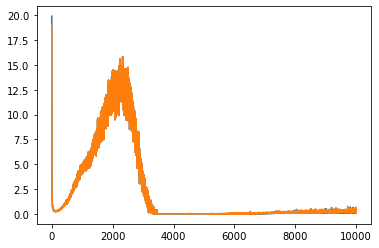

In [42]:
plt.plot(q1_loss_hist)
plt.plot(q2_loss_hist)

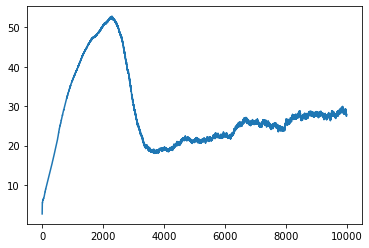

In [43]:
plt.plot(pi_loss_hist)

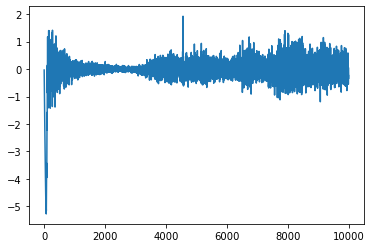

In [44]:
plt.plot(alpha_loss_hist)

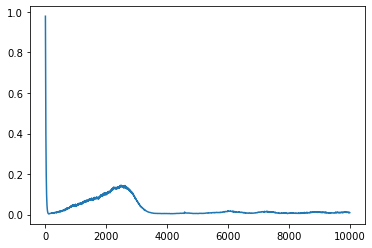

In [45]:
plt.plot(alpha_hist)

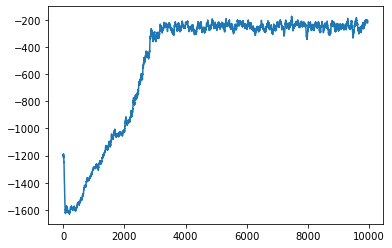

In [46]:
smoothed = []
b_idx = 0
e_idx = 50
while e_idx <= len(r_hist):
    smoothed.append(np.mean(r_hist[b_idx:e_idx]))
    b_idx += 1
    e_idx += 1

plt.plot(smoothed)

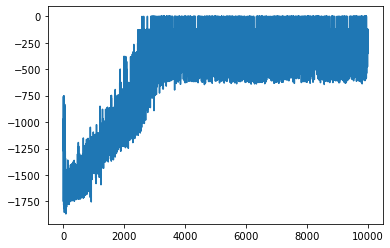

In [47]:
plt.plot(r_hist)

In [48]:
np.mean(r_hist[-100:])

-211.66646162878976

In [49]:
np.std(r_hist[-100:])

148.84487093667096

In [93]:
now = agent.q1.state_dict()

In [97]:
for k in now.keys():
    print(torch.sum(now[k] - then[k]))

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


In [75]:
agent.q1.state_dict()

OrderedDict([('inp.weight',
              tensor([[-0.3731, -0.1800, -0.3192, -0.3072],
                      [ 0.0995, -0.2154,  0.0454, -0.3730],
                      [-0.0567, -0.1843,  0.4676, -0.0284],
                      ...,
                      [-0.3153, -0.2354,  0.3395,  0.2192],
                      [-0.2723,  0.2211,  0.4713,  0.2597],
                      [-0.0038,  0.1912, -0.0373,  0.2811]], device='cuda:0')),
             ('inp.bias',
              tensor([ 0.2298, -0.2304, -0.1039,  0.0824,  0.3861,  0.1501,  0.4740, -0.0769,
                      -0.3661,  0.1228,  0.1402,  0.3913, -0.4661,  0.2085,  0.1818, -0.4614,
                       0.0892,  0.2105, -0.2752,  0.2164,  0.2491, -0.4515,  0.2544, -0.4526,
                       0.0242, -0.0146, -0.2005,  0.2987, -0.2669,  0.4282, -0.3757,  0.4563,
                       0.3335, -0.2404,  0.4421, -0.2406, -0.1603,  0.0912,  0.3378, -0.1918,
                      -0.3271, -0.0131, -0.0068, -0.4162,  0.1020,  0

In [72]:
agent.qtarget1.state_dict()

OrderedDict([('inp.weight',
              tensor([[-0.3731, -0.1801, -0.3193, -0.3073],
                      [ 0.0994, -0.2154,  0.0455, -0.3731],
                      [-0.0568, -0.1843,  0.4678, -0.0285],
                      ...,
                      [-0.3154, -0.2355,  0.3396,  0.2191],
                      [-0.2724,  0.2212,  0.4714,  0.2596],
                      [-0.0038,  0.1913, -0.0373,  0.2810]], device='cuda:0')),
             ('inp.bias',
              tensor([ 0.2299, -0.2303, -0.1038,  0.0825,  0.3862,  0.1502,  0.4739, -0.0768,
                      -0.3660,  0.1227,  0.1403,  0.3912, -0.4660,  0.2084,  0.1818, -0.4615,
                       0.0893,  0.2106, -0.2753,  0.2165,  0.2492, -0.4516,  0.2545, -0.4525,
                       0.0241, -0.0147, -0.2004,  0.2988, -0.2670,  0.4283, -0.3758,  0.4564,
                       0.3334, -0.2403,  0.4422, -0.2406, -0.1602,  0.0912,  0.3379, -0.1917,
                      -0.3272, -0.0131, -0.0067, -0.4162,  0.1019,  0

In [74]:
agent.qtarget1.state_dict()

OrderedDict([('inp.weight',
              tensor([[-0.3731, -0.1800, -0.3192, -0.3072],
                      [ 0.0995, -0.2154,  0.0454, -0.3730],
                      [-0.0567, -0.1843,  0.4677, -0.0284],
                      ...,
                      [-0.3153, -0.2354,  0.3395,  0.2192],
                      [-0.2723,  0.2211,  0.4713,  0.2597],
                      [-0.0038,  0.1912, -0.0373,  0.2811]], device='cuda:0')),
             ('inp.bias',
              tensor([ 0.2298, -0.2304, -0.1039,  0.0824,  0.3861,  0.1501,  0.4740, -0.0769,
                      -0.3661,  0.1228,  0.1402,  0.3913, -0.4661,  0.2085,  0.1818, -0.4614,
                       0.0892,  0.2105, -0.2752,  0.2164,  0.2491, -0.4516,  0.2544, -0.4526,
                       0.0242, -0.0146, -0.2005,  0.2987, -0.2669,  0.4282, -0.3757,  0.4563,
                       0.3335, -0.2404,  0.4421, -0.2406, -0.1603,  0.0912,  0.3378, -0.1918,
                      -0.3271, -0.0131, -0.0068, -0.4162,  0.1020,  0

In [71]:
agent.soft_param_update()

In [265]:
s, a, r, s_, t = agent.memory.sample(10)

In [268]:
next_a, _ = agent.pi.sample_action(torch.tensor(s_, dtype=torch.float))
next_a

tensor([[-0.1137],
        [-0.6573],
        [-0.5327],
        [-0.7683],
        [-0.5071],
        [-0.4362],
        [ 0.9135],
        [ 0.8412],
        [-0.9937],
        [ 0.1618]], grad_fn=<TanhBackward>)

In [269]:
torch.cat([torch.tensor(s_), next_a], dim=1)

tensor([[-0.8501, -0.5267, -3.2128, -0.1137],
        [-0.5914, -0.8064,  1.9603, -0.6573],
        [-0.8977, -0.4406,  3.7338, -0.5327],
        [-0.7017,  0.7124, -3.2745, -0.7683],
        [-0.8717, -0.4900,  3.7079, -0.5071],
        [-0.9439, -0.3302,  4.3137, -0.4362],
        [-0.5333, -0.8459,  1.4064,  0.9135],
        [-0.6144,  0.7890, -2.9354,  0.8412],
        [-0.6745,  0.7383,  2.7284, -0.9937],
        [-0.4656,  0.8850,  0.6915,  0.1618]], dtype=torch.float64,
       grad_fn=<CatBackward>)

In [149]:
dones * rewards

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [5.],
        [0.]])

In [150]:
rewards + dones * 0.99 * rewards

tensor([[1.9900],
        [2.0000],
        [3.0000],
        [4.0000],
        [9.9500],
        [6.0000]])

In [151]:
dones * 0.99 * rewards

tensor([[0.9900],
        [0.0000],
        [0.0000],
        [0.0000],
        [4.9500],
        [0.0000]])

# s = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

s = torch.tensor(s, dtype=torch.float)
s

In [114]:
torch.cat([s, s], dim=1)

tensor([[1., 2., 3., 1., 2., 3.],
        [4., 5., 6., 4., 5., 6.],
        [7., 8., 9., 7., 8., 9.]])

In [142]:
test = QNetwork(10, 3, 1)

s = np.array([[x for x in range(10)], [x for x in range(10)], [x for x in range(10)]])
a = np.array([[x for x in range(3)], [x for x in range(3)], [x for x in range(3)]])
s = torch.tensor(s, dtype=torch.float)
a = torch.tensor(a, dtype=torch.float)
sa_cat = torch.cat([s, a], dim=1)

q1 = test(sa_cat)

test = QNetwork(10, 3, 1)

q2 = test(sa_cat)

In [143]:
print(q1)
print(q2)

tensor([[0.],
        [0.],
        [0.]], grad_fn=<ReluBackward0>)
tensor([[0.3051],
        [0.3051],
        [0.3051]], grad_fn=<ReluBackward0>)


In [147]:
torch.tensor(
    np.array([1, 0, 0, 0, 1, 0]),
    dtype=torch.float
).unsqueeze(1)

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]])

In [122]:
q2

tensor([[0.6314]], grad_fn=<ReluBackward0>)

In [118]:
torch.tensor(np.array([x for x in range(10)]), dtype=torch.float).unsqueeze(0)

tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]])

In [105]:
test = QNetwork(10, 3, 1)
p = test.state_dict()
test.state_dict()

OrderedDict([('inp.weight',
              tensor([[ 0.0304, -0.1035,  0.2134,  ...,  0.0365,  0.1818,  0.1708],
                      [ 0.0964, -0.0088,  0.0405,  ...,  0.2354, -0.0939,  0.1486],
                      [-0.1578,  0.0360,  0.0541,  ...,  0.0367, -0.1757,  0.1212],
                      ...,
                      [ 0.2672,  0.0679,  0.0935,  ...,  0.1895, -0.1087, -0.0212],
                      [ 0.1469,  0.1968, -0.0811,  ...,  0.1725,  0.0384, -0.2246],
                      [ 0.1134,  0.2695, -0.1413,  ..., -0.1740,  0.2642, -0.0428]])),
             ('inp.bias',
              tensor([ 0.1933, -0.1701,  0.1741,  0.2057,  0.1697, -0.1995,  0.2379,  0.2221,
                       0.2127, -0.1698, -0.0435,  0.1291, -0.0954, -0.1706,  0.2642,  0.1521,
                       0.0649, -0.2444,  0.1387,  0.1471,  0.2634, -0.0079, -0.2257,  0.2587,
                       0.1845, -0.2516, -0.0468, -0.2756,  0.1786, -0.2400,  0.2554,  0.0936,
                       0.2141, -0.11

In [106]:
for key in p.keys():
    p[key] *= 0.01
test.state_dict()

OrderedDict([('inp.weight',
              tensor([[ 3.0387e-04, -1.0348e-03,  2.1342e-03,  ...,  3.6517e-04,
                        1.8180e-03,  1.7075e-03],
                      [ 9.6372e-04, -8.8379e-05,  4.0494e-04,  ...,  2.3539e-03,
                       -9.3946e-04,  1.4865e-03],
                      [-1.5780e-03,  3.6046e-04,  5.4069e-04,  ...,  3.6744e-04,
                       -1.7573e-03,  1.2117e-03],
                      ...,
                      [ 2.6725e-03,  6.7912e-04,  9.3484e-04,  ...,  1.8945e-03,
                       -1.0874e-03, -2.1201e-04],
                      [ 1.4694e-03,  1.9685e-03, -8.1121e-04,  ...,  1.7247e-03,
                        3.8447e-04, -2.2460e-03],
                      [ 1.1336e-03,  2.6954e-03, -1.4128e-03,  ..., -1.7402e-03,
                        2.6418e-03, -4.2813e-04]])),
             ('inp.bias',
              tensor([ 1.9329e-03, -1.7009e-03,  1.7406e-03,  2.0574e-03,  1.6975e-03,
                      -1.9954e-03,  2.3794e

In [100]:
test.state_dict()

OrderedDict([('inp.weight',
              tensor([[ 1.6208e-03,  7.6350e-04,  2.7396e-03,  ..., -2.3728e-03,
                       -2.7441e-03, -1.2152e-03],
                      [-2.2653e-03,  4.9927e-04,  2.4670e-03,  ..., -7.7872e-05,
                        1.2097e-03, -2.6899e-03],
                      [ 1.5258e-03, -1.2957e-03,  4.4453e-04,  ..., -4.6565e-04,
                        9.4918e-04,  1.8954e-03],
                      ...,
                      [ 1.5395e-03,  6.7209e-04, -3.6641e-04,  ...,  1.9100e-03,
                        1.7140e-03,  2.4130e-03],
                      [-7.0626e-04,  1.4858e-03,  3.9183e-04,  ..., -2.2896e-03,
                        1.4543e-03,  2.4794e-03],
                      [ 2.3049e-03,  1.4009e-03, -2.1746e-03,  ..., -7.0786e-05,
                        1.2669e-03, -1.9307e-03]])),
             ('inp.bias',
              tensor([-5.3628e-04, -9.5116e-04, -7.5733e-04,  1.5539e-03,  2.0863e-03,
                      -7.2791e-05, -1.6991e

In [95]:
test.state_dict()

OrderedDict([('inp.weight',
              tensor([[ 2.5780e-03, -1.3305e-03,  1.1003e-03,  ..., -1.7611e-03,
                       -7.7126e-05,  1.7861e-03],
                      [-1.3549e-03, -1.9893e-03,  1.4467e-03,  ..., -9.6229e-04,
                       -2.1250e-03,  4.2955e-04],
                      [ 1.0242e-03,  2.0525e-03,  1.2771e-04,  ..., -7.9851e-04,
                       -1.5987e-03, -2.0076e-03],
                      ...,
                      [-1.9853e-03,  1.2958e-03, -2.5535e-03,  ..., -1.4817e-03,
                       -4.5934e-04,  1.1430e-03],
                      [ 1.7618e-03,  5.9932e-04,  2.6225e-03,  ...,  9.8021e-04,
                       -7.5687e-04,  1.7381e-03],
                      [-6.6507e-04, -1.9517e-03, -1.6897e-03,  ..., -2.1596e-03,
                       -1.2661e-03, -2.7025e-03]])),
             ('inp.bias',
              tensor([ 1.9140e-03,  1.5870e-03,  1.0729e-03, -1.7376e-03, -2.1374e-03,
                       2.2983e-03,  1.7347e

In [43]:
    

# class PolicyNetwork(nn.Module):
#     def __init__(self, s_shape):
#         super().__init__()
#         if len(s_shape) > 1:
#             self.l1 = nn.Conv2d(3, 8, (5, 5), stride=2)
#             self.l2 = nn.Conv2d(8, 16, (3, 3), stride=2)
#             self.l3 = nn.Conv2d(16, 3, (3, 3), stride=2)
            
            
#     def forward(self, x):
#         x = F.relu(self.l1(x))
#         x = F.relu(self.l2(x))
#         x = F.relu(self.l3(x))
#         x = x.view(x.size(0), -1)
#         print(x.shape)

In [44]:
PolicyNetwork(s_shape=(3, 84, 84))(torch.rand((1, 3, 84, 84)))

torch.Size([1, 243])


In [60]:
s_norm = Normal(torch.tensor([1, 0.2, 3]), torch.tensor([1, 0.9, 0.2]))

In [61]:
actions = s_norm.rsample()
actions

tensor([2.5093, 0.4391, 2.9150])

In [62]:
torch.tanh(actions)

tensor([0.9869, 0.4129, 0.9941])

In [59]:
torch.tensor([2.2, 1.1]).exp()

tensor([9.0250, 3.0042])